In [2]:
import matplotlib.pyplot as plt
import numpy as np
import dsdl
import numpy.random
from typing import Callable, List
import pandas as pd
import json

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# !pip install git+https://github.com/fkunstner/dataset-downloader.git

In [4]:
DATASETS = ['a1a', 'mushrooms', 'a6a', 'w1a', 'w5a', 'ionosphere']
METHODS = ['SGD', 'AdaSpider', 'Spider', 'SpiderBoost', 'SVRG', 'AdaGrad', 'AdaSVRG']

In [5]:
import os
import sys
module_path = "/root/ML-Reproducibility-Challange/"
if module_path not in sys.path:
    sys.path.append(module_path)

# Logistic regression

In [6]:
# for dataset_name in DATASETS:
#     X, y = get_data(dataset_name)
#     pd.DataFrame(np.c_[X, y]).to_csv(f"{dataset_name}.csv", index=False)

In [7]:
from src.optimizers.Optimizer import Optimizer

In [8]:
def get_data(dataset_name: str):
    """
    :param dataset_name: Name of the dataset from dsdl module.
    :return: (X, y) train and target data.
    """
    ds = dsdl.load(dataset_name)
    X, y = ds.get_train()
    X = X.toarray()
    y = y.reshape(-1, 1)
    return X, y

def build_model(X, y):
    """
    Joins weights
    :param X: shape=(N, D). Train data
    :param y: shape=(N, 1). Target data
    :return: shape=(N, D+1). Built model for logistic regression.
    """
    return np.c_[np.zeros((y.shape[0], 1)), X]

def get_initial_weights(tx):
    """
    Returns weights initialized from the uniform distribution [0, 1].
    :param tx: shape=(N, D). Build model
    :return: shape=(D, 1) Initial weights
    """
    np.random.seed(2022)
    return np.zeros(shape=(tx.shape[1], 1))

def test_method(method: Optimizer,
                initial_weights,
                tx,
                y,
                max_iter: int,
                *parameter):
        """
        :param method: Optimization method implementation from src optimizers module.
        :param dataset_name: Name of the dataset from dsdl module.
        :param max_iter: Number of iterations to test.
        :param parameters optional: Dataclass containing parameters used int optimization method.
        :return: List of gradients from optimization method.
        """
        gradients, loss = method.optimize(initial_weights, tx, y, max_iter)
        return [np.linalg.norm(grad, 2) for grad in gradients], loss

In [9]:
from src.optimizers.SGD import SGD
from src.optimizers.AdaSpider import AdaSpider
from src.optimizers.Spider import Spider
from src.optimizers.SpiderBoost import SpiderBoost
from src.optimizers.SVRG import SVRG
from src.optimizers.AdaGrad import AdaGrad
from src.optimizers.AdaSVRG import AdaSVRG

In [10]:
N_ORACLE_CALLS = 10

METHODS = [
    SGD(lambda_=0.0001, q=N_ORACLE_CALLS),
    AdaSpider(q=N_ORACLE_CALLS),
    Spider(n_0 = 0.0001, epsilon=0.0001, q=N_ORACLE_CALLS),
    SpiderBoost(q=N_ORACLE_CALLS),
    SVRG(lambda_=0.0001, q=N_ORACLE_CALLS),
    AdaGrad(lambda_=0.0001, epsilon= 0.0001, q=N_ORACLE_CALLS),
    AdaSVRG(lambda_=0.0001, q=N_ORACLE_CALLS)
]

## Run simulations

In [11]:
# run 2 # 20 mins on 8 cpu avs ml.c5.2xlarge
# run 1 # 1 hour later on the 4 cpu machine 

In [12]:
ITERATIONS = 10000
N_RUNS = 5

all_gradients = []

datasets_data = {}
for i, dataset_name in enumerate(DATASETS):

    print("Dataset", dataset_name)

    X, y = get_data(dataset_name)
    tx = build_model(X, y)
    initial_weights = get_initial_weights(tx)

    methods_data = {}
    for method, n_runs in zip(METHODS, [5,1,1,1,1,1,5]):
        print("Method", method.name)

        gradients_5_runs = list()
        for _ in range(n_runs):
            gradients, _ = test_method(method, initial_weights, tx, y, ITERATIONS)
            gradients_5_runs.append(gradients)
        gradients_mean = np.mean(gradients_5_runs, axis=0)

        stddev = np.std(gradients_5_runs, axis=0)
        lower = gradients_mean - stddev
        upper = gradients_mean + stddev

        methods_data[method.name] = {
            "gradient_mean": list(gradients_mean),
            "lower": list(lower),
            "upper": list(upper),
            "n_runs": N_RUNS,
            "n_iterations": ITERATIONS
        }
        datasets_data[dataset_name] = methods_data

    break  # plot single dataset
print("DONE")

Dataset a1a
Method SGD
Method AdaSpider
Method Spider
Method SpiderBoost
Method SVRG
Method AdaGrad
Method AdaSVRG
DONE


In [13]:
with open('run_3.json', 'w') as file:
    json.dump(datasets_data, file)

In [14]:
# get the mean length of gradients
print("DONE")
min_length = None
for key, val in datasets_data['a1a'].items():
    current_length = len(val['gradient_mean'])
    if min_length is None:
        min_length = current_length
    elif min_length > current_length:
        min_length = current_length
min_length

DONE


1000

### Plot

Dataset a1a
Method SGD
Method AdaSpider
Method Spider
Method SpiderBoost
Method SVRG
Method AdaGrad
Method AdaSVRG


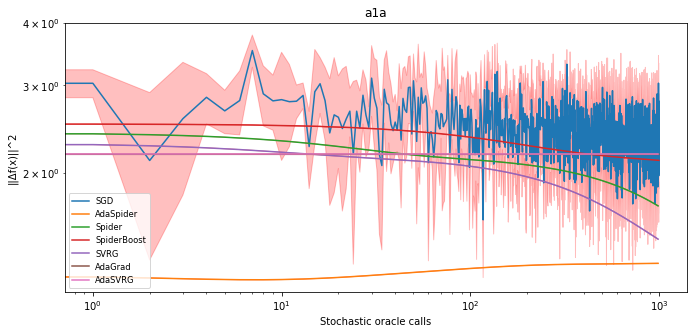

In [18]:
X_LABEL = "Stochastic oracle calls"
Y_LABEL = "||\u0394f(x)||^2"

fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=False, sharex=False)  # 3, 2

for i, dataset_name in enumerate(DATASETS):
    print("Dataset", dataset_name)

    methods_data = datasets_data[dataset_name]

    # sbplt = ax[i%3, i%2]
    sbplt = ax

    for method_name, method_data in methods_data.items():
        print("Method", method_name)

        gradients_mean = method_data['gradient_mean'][10:]
        lower = method_data['lower'][10:]
        upper = method_data['upper'][10:]
        n_iterations = method_data['n_iterations']

        sbplt.plot(gradients_mean[:min_length], label=method_name)
        sbplt.fill_between(list(range(len(gradients_mean[:min_length]))), lower[:min_length], upper[:min_length], alpha=0.25,
                           facecolor='red', edgecolor='red')

    sbplt.set_xscale('log')
    sbplt.set_yscale('log')
    sbplt.set_title(dataset_name)
    sbplt.set_xlabel(X_LABEL)
    sbplt.set_ylabel(Y_LABEL)
    sbplt.legend(loc='lower left', fontsize='small')

    break  # plot single dataset

fig.tight_layout(pad=2.0)
fig.savefig(f'tests_logistic_regression_run_3.jpg', dpi=300)

# plot_data()

Do parameter sweep

In [23]:
from itertools import product

In [26]:
REDUCTION_STEP = 10

METHODS = [
    SGD(lambda_=0.01, q=REDUCTION_STEP),
    # AdaSpider(q=REDUCTION_STEP),
    Spider(n_0 = 1, epsilon=0.01, q=REDUCTION_STEP),
    SpiderBoost(q=REDUCTION_STEP),
    SVRG(lambda_=0.001, q=REDUCTION_STEP),
    AdaGrad(lambda_=0.5, epsilon= 0.00001, q=REDUCTION_STEP),
    AdaSVRG(lambda_=0.1, q=REDUCTION_STEP)
]

DF_COLUMNS = ['method_name', 'loss', 'parameters']
df = pd.DataFrame(columns=DF_COLUMNS)

dataset_name = 'a1a'
ITERATIONS = 1000
print("Dataset", dataset_name, "Iterations: ", ITERATIONS)

powers = np.array([range(-5, 0)], dtype=float)
parameters = 10**powers.flatten()

X, y = get_data(dataset_name)
tx = build_model(X, y)
initial_weights = get_initial_weights(tx)

for method in METHODS:
    print("Method", method.name)
    if method.n_params_to_tune == 2:
        for param in list(product(parameters, parameters)):
            method.set_params(param[0], param[1])
            _, losses = test_method(method, initial_weights, tx, y, ITERATIONS)
            df = df.append(dict(zip(DF_COLUMNS, [method.name, np.sum(losses), str(param)])), ignore_index=True)

    elif method.n_params_to_tune == 1:
        for param in parameters:
            method.set_params(param)
            _, losses = test_method(method, initial_weights, tx, y, ITERATIONS)
            df = df.append(dict(zip(DF_COLUMNS, [method.name, np.sum(losses), str(param)])), ignore_index=True)
    else:
        _, losses = test_method(method, initial_weights, tx, y, ITERATIONS)
        df = df.append(dict(zip(DF_COLUMNS, [method.name, np.sum(losses), str(param)])), ignore_index=True)

Dataset a1a Iterations:  1000
Method SGD
Method Spider
Method SpiderBoost
Method SVRG
Method AdaGrad


/root/ML-Reproducibility-Challange/src/logistic_regression/log_reg.py:41: RuntimeWarning: overflow encountered in exp
  first_component = np.log(1 + np.exp(tx.dot(w)))


Method AdaSVRG


TypeError: set_params() missing 1 required positional argument: 'new_epsilon'

In [ ]:
df.to_csv("parameters_sweep_3.csv", index=False)

In [53]:
df['loss'] = df['loss'].abs()
df.groupby('method_name').min()

,loss,parameters
method_name,,
AdaGrad,3432.160706,"(0.0001, 0.0001)"
AdaSVRG,851480.257577,0.0001
SGD,902.078086,0.0001
SVRG,1148.117316,0.0001
Spider,2270.080086,"(0.0001, 0.0001)"
SpiderBoost,2203.122416,"(0.1, 0.1)"


In [65]:
# METHODS = ['AdaSpider', 'Spider']
# ITERATIONS = 100
#
# def plot_data():
#     # Write your code to make 4x4 panel here
#     X_LABEL = "Stochastic oracle calls"
#     Y_LABEL = "||\u0394f(x)||^2"
#
#     fig, ax = plt.subplots(3,2,figsize=(16,16), sharey=False, sharex=False)
#
#     for i, dataset_name in enumerate(DATASETS):
#         sbplt = ax[i%3, i%2]
#         print(dataset_name)
#         for method in METHODS:
#             if method == "Spider":
#                 spider_params = SpiderParam(100, 5, 0.05)
#                 gradients = test_method(Spider, dataset_name, ITERATIONS, spider_params)
#             else:
#                 gradients = test_method(ADASpider, dataset_name, ITERATIONS)
#             gradients = [np.linalg.norm(grad, 2) for grad in gradients]
#             sbplt.plot(gradients, label=method)
#
#         sbplt.set_xscale('log')
#         sbplt.set_title(dataset_name)
#         sbplt.set_xlabel(X_LABEL)
#         sbplt.set_ylabel(Y_LABEL)
#         sbplt.legend(loc='lower left')
#
#         break  # plot single dataset
#
#     fig.tight_layout(pad=2.0)
#     # fig.savefig('tests_logistic_regression.jpg', dpi=150)
#
# plot_data()